In [43]:
%run stdPackages.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# A Basic Model of the Electricity System with Hourly Variation

We consider a ```mBasicInt```-like model that can be represented by the optimization problem:

$$\begin{align}
    \max W &= \sum_h\left(\sum_c u_c\cdot D_{h,c}-\sum_i c_i \cdot E_{h,i}\right)-\sum_i \text{FOM}_i\cdot q_i \tag{1a} \\
    \sum_c D_{h,c} &= \sum_i E_{h,i} \tag{1b} \\
    c_i &= c_i^{oth}+\sum_j\mu_j^i\cdot p_j^f + p_{CO2} \cdot \nu_i \tag{1c} \\
    \nu_i &= \sum_j\mu_j^i\phi_j \tag{1d} \\
    D_{h,c} &\in[0, L_{h,c}], \qquad L_{h,c} \equiv L_c \cdot \upsilon_{h,c} \tag{1e} \\ 
    E_{h,i} &\in[0, q_{h,i}], \qquad q_{h,i} \equiv q_i\cdot \gamma_{h,i} \tag {1f}
\end{align}$$


Here:
* $u_c$ is the marginal willingness to pay for electricity for consumer $c$ (*the model only includes one consumer though*).
* $D_{h,c}$ is the consumption of electricity in hour $h$ by consumer $c$.
* $c_i$ is the marginal cost of generation for plant $i$. 
* $E_{h,i}$ is the MWh of electricity generation in hour $h$ for plant $i$.
* $\text{FOM}_i$ is the fixed cost of plant $i$. This is measured as 1000 €/MW generating capacity (i.e. 1000 € per $q_i$)
* $q_i$ is the installed generating capacity of plant $i$.
* $\mu_j^i$ is the input-share of energy carrier $j$ for generator $i$ (i.e. MWh input of fuel $j$ per MWh output from generator $i$).
* $p_j^f$ is the price of carrier $j$ measured in €/MWh.
* $p_{CO2}$ is a tax on CO2 emissions (€/ton CO2).
* $\nu_i$ is the emission intensity of generator $i$ (i.e. ton of CO2 per MWh of output generated by plant $i$).
* $\phi_j$ is the emission intensity of energy carrier $j$.
* $L_c$ is the yearly maximum load in MWh,
* $L_{h,c}$ is the maximum load/demand consumer $c$ has in hour $h$, with $\upsilon_{h,c}\in[0,1]$ reflecting variation in demand.
* $q_{h,i}$ is the hourly generating capacity of plant $i$, with $\gamma_{h,i}\in[0,1]$ reflecting variation in natural conditions e.g. wind speed.

The file *PS4.xlsx* includes some simulated hourly variation data that we will use throughout. Table 1 translates the names used in the data to the symbols in the model. The data uses 12 representative days - one for each month of the year - to represent the yearly variation in an electricity system. Thus, the data includes 24$\cdot$12 $=$ 288 hours in total. Tables 1-2 translates the names used in the data to the symbols used in the model above:

| **Table 1: Symbols Dictionary** | |
| --- | --- |
| *Name in excel data* | *Model Symbol* |
| FuelMix | $\mu_j^i$ |
| EmissionIntensity | $\phi_j$ |
|FuelPrice | $p_j^f$ |
| EmissionTax | $p_{CO2}$ |
| Load | $L_c$ |
| LoadVariation | $\upsilon_{h,c}$ |
| MWP | $u_c$ |
| GeneratingCapacity | $q_i$ |
| CapVariation | $\gamma_{h,i}$ |
| OtherMC | $c_i^{oth}$ |
| FOM | $\text{FOM}_i$ |

| **Table 2: Index Dictionary** | |
| --- | --- |
| *Name in excel data* | *Model Index* |
| BFt | $j$ |
| id | $i$ |
| h | $h$ |
| c | $c$ |

*The following uses the package ```pyDbs``` to load and arrange the data in a simple key,value like database. It has a few methods that reads in symbols from excel and add them as pandas series with the appropriate pandas indices. This is what we use here to read in the data:*

In [44]:
db = pyDbs.read.dbFromWB(os.path.join(d['data'], 'PS4.xlsx'),
                        {'variables': ['Fundamentals','Load','Generator'],
                         'variable2D': ['FuelMix', 'HourlyVariation'],
                         'maps': ['GeneratorCategories']})
pyDbs.readSets(db) # this method adds indices from the declared symbols to the database.

*Note: In the data, the hourly variation in generating capacity is defined over an index ```hvt``` which is simply short for "hourly variation types". As you can see in the data, "standard" with a constant hourly productivity $\gamma_{h,i} = 1$ or the type "Wind". The mapping ```id2hvt``` shows what category the three plants are in this model; only plant 'C' is a "wind" type.*

## Q1. Writing a Model Class

Consider the optimization model in equations (1). In this exercise, we will build an energy system model to solve this based on the ```lpModels``` framework. You should write this custom model class in the file ```pyfiles/E4.py```. This file already includes some base functions that you should apply throughout.

*This snippet loads the classes/methods that you've defined in ```pyfiles/E4.py:```*

In [45]:
os.chdir(d['curr'])
from pyfiles.E4 import * # this imports everything from the file

### **Q1.1. Test and explain base functions in the class**

*The ```customModel``` class in ```E4.py``` already contains a number of methods. Now, initialize an instance of the class with the database ```db``` from above and use the method ```mc``` from the ```E4.py``` file to compute the marginal costs of the different plants; add this to the database.*

*Test and briefly explain the following:*
1. *What does it mean that ```h``` and ```h_constr``` are aliased?*
2. *What does ```hourlyGeneratingCapacity``` return?*
2. *What does ```hourlyCapFactors``` return?*
2. *What does ```hourlyLoad_c``` return?*

In [46]:
m = customModel(db) # initialize
m.db['mc'] = mc(db) # add marginal costs to the database (1c)

In [47]:
(m.db['h_constr'] == m.db['h']).all() # They are the same

True

In [48]:
m.hourlyGeneratingCapacity['A'] #hourly generating capacity of plant A for each hour of the twelve representative days


h
(1, 1)      60
(1, 2)      60
(1, 3)      60
(1, 4)      60
(1, 5)      60
            ..
(12, 20)    60
(12, 21)    60
(12, 22)    60
(12, 23)    60
(12, 24)    60
Length: 288, dtype: object

In [49]:
m.hourlyCapFactors #Returns the flexibility of each plant in each hour, the non-wind power plants == 1 

h        id
(1, 1)   A            1
         B            1
(1, 10)  A            1
         B            1
(1, 11)  A            1
                 ...   
(9, 5)   C     0.030942
(9, 6)   C     0.022674
(9, 7)   C     0.019218
(9, 8)   C      0.70672
(9, 9)   C     0.010767
Length: 864, dtype: object

In [50]:
m.hourlyLoad #Consumed demand from all plants 

h
(1, 1)      80.368826
(1, 10)    147.243368
(1, 11)    147.953656
(1, 12)    145.739041
(1, 13)    142.964219
              ...    
(9, 5)      60.264261
(9, 6)      61.376487
(9, 7)      64.413918
(9, 8)     107.513028
(9, 9)     113.181667
Length: 288, dtype: object

### **Q1.2. The ```globalDomains``` property**

The property ```globalDomains``` helps to keep track of what symbols (e.g. $E$ and $D$) are defined over what sets; it is a dictionary where the key = the name of the symbol and the value =  the ```pd.Index``` that the symbol is defined over. In the ```mBasic``` model that we saw in problem set 3, for instance, the ```globalDomains``` property looked like this:

```python
    @property
    def globalDomains(self):
        return {'Generation': self.db['id'],
                'Demand': self.db['c']}
```


In the model in equations (1), the model ultimately consists of two variables ($E_{i,h}$ and $D_{c,h}$) and one variational constraint (the equilibrium one in 1b). The global domains method is defined as 

```python 
	@property
	def globalDomains(self):
		return {'Generation': pd.MultiIndex.from_product([self.db['h'], self.db['id']]),
				'HourlyDemand': pd.MultiIndex.from_product([self.db['c'], self.db['h']]),
				'equilibrium': self.db['h_constr']}
```

*Test and explain each line briefly*

In [51]:
m.globalDomains #No idea what this is

{'Generation': MultiIndex([(  '(1, 1)', 'A'),
             (  '(1, 1)', 'B'),
             (  '(1, 1)', 'C'),
             (  '(1, 2)', 'A'),
             (  '(1, 2)', 'B'),
             (  '(1, 2)', 'C'),
             (  '(1, 3)', 'A'),
             (  '(1, 3)', 'B'),
             (  '(1, 3)', 'C'),
             (  '(1, 4)', 'A'),
             ...
             ('(12, 21)', 'C'),
             ('(12, 22)', 'A'),
             ('(12, 22)', 'B'),
             ('(12, 22)', 'C'),
             ('(12, 23)', 'A'),
             ('(12, 23)', 'B'),
             ('(12, 23)', 'C'),
             ('(12, 24)', 'A'),
             ('(12, 24)', 'B'),
             ('(12, 24)', 'C')],
            names=['h', 'id'], length=864),
 'HourlyDemand': MultiIndex([('Consumer 1',   '(1, 1)'),
             ('Consumer 1',   '(1, 2)'),
             ('Consumer 1',   '(1, 3)'),
             ('Consumer 1',   '(1, 4)'),
             ('Consumer 1',   '(1, 5)'),
             ('Consumer 1',   '(1, 6)'),
             ('Consume

### **Q1.3. Add domain constraints/bounds to the model**

In the ```customModel``` class, we have already added a method that defines the ```c```-vector of the linear programming (LP) problem (cf. ```lpCompiler_PartI.ipynb``` in the documentation folder). Specifically, we have:

```python
    @property
	def c(self):
		return [{'varName': 'Generation', 'value': adjMultiIndex.bc(self.db['mc'], self.db['h'])},
				{'varName': 'HourlyDemand', 'value': -adjMultiIndex.bc(self.db['MWP'], self.globalDomains['HourlyDemand'])}]
```

For the symbol 'Generation', for instance, this specifies that the ```c```-vector in the LP problem should consist of the marginal costs repeated for all hours:

In [52]:
m.c[0]['value']

id  h       
A   (1, 1)      23.407048
    (1, 2)      23.407048
    (1, 3)      23.407048
    (1, 4)      23.407048
    (1, 5)      23.407048
                  ...    
C   (12, 20)          5.0
    (12, 21)          5.0
    (12, 22)          5.0
    (12, 23)          5.0
    (12, 24)          5.0
Length: 864, dtype: object

For the symbol 'HourlyDemand', this repeats the marginal willingness to pay to all hours:

In [53]:
m.c[1]['value']

c           h      
Consumer 1  (1, 1)     -100
            (1, 10)    -100
            (1, 11)    -100
            (1, 12)    -100
            (1, 13)    -100
                       ... 
            (9, 5)     -100
            (9, 6)     -100
            (9, 7)     -100
            (9, 8)     -100
            (9, 9)     -100
Length: 288, dtype: object

*Use this syntax to define the upper bound vector ```u``` of the problem, by writing the missing lines for the property ```self.u``` in the model class.*

In [57]:
m.u[1]['value']

c           h       
Consumer 1  (1, 1)       80.368826
            (1, 2)       77.316503
            (1, 3)       75.689608
            (1, 4)       74.997063
            (1, 5)       75.078476
                           ...    
            (12, 20)     133.27888
            (12, 21)    125.158381
            (12, 22)      96.91692
            (12, 23)     90.479093
            (12, 24)     84.081333
Length: 288, dtype: object

### **Q1.4. Explain the rest of the model specification**

Recall from ```lpCompiler_PartI.ipynb``` from the documentation that the classes we build here can help us fill in some default values. For instance:
* If no value of ```c``` is provided for generator $i$ in hour $h$ - the model fills in a zero here.
* If no value of ```l``` is provided, it uses a zero as well.
* If no value of ```u``` is provided, it uses a ```np.inf``` (no bound).

Similarly, if we have not provided information on parts of the other components (the vectors ```b_eq, b_ub``` or the matrices ```A_eq, A_ub```), the compiler fills in zeros here as well.


*Using what you have read in the documentation, make sure that you understand how this small snippet defines the entire model in equations (1).*

```python
@property
	def c(self):
		return [{'varName': 'Generation', 'value': adjMultiIndex.bc(self.db['mc'], self.db['h'])},
				{'varName': 'HourlyDemand', 'value': -adjMultiIndex.bc(self.db['MWP'], self.globalDomains['HourlyDemand'])}]
	@property
	def u(self):
		return [{'varName': 'Generation', 'value': self.hourlyGeneratingCapacity},
				{'varName': 'HourlyDemand', 'value': self.hourlyLoad_c}]
	@property
	def b_eq(self):
		return [{'constrName': 'equilibrium'}]
	@property
	def A_eq(self):
		return [{'constrName': 'equilibrium', 'varName': 'Generation', 'value': appIndexWithCopySeries(pd.Series(1, index = self.globalDomains['Generation']), 'h','h_constr')},
				{'constrName': 'equilibrium', 'varName': 'HourlyDemand', 'value': appIndexWithCopySeries(pd.Series(-1, index = self.globalDomains['HourlyDemand']), 'h','h_constr')}]
```

## Q2. Solution and experiments in ```customModel```

### **Q2.1. Draw and explain the *load duration curve* and *residual demand curve***

*Hint: You should end up with a plot that looks something like this (you don't need the plot to be fancy)*

In [71]:
LDC = m.hourlyLoad.sort_values(ascending=False) #Sorts the load in descending order
LDC.index = [i/len(LDC) for i in range(1, len(LDC)+1)] # Set the index to the share of the year that has passed at hour 'h'

In [82]:
RDC = m.hourlyLoad-m.hourlyGeneratingCapacity.xs('C', level = 'id') # demand w/o wind type
RDCL = RDC.sort_values(ascending=False) #Sorts the load in descending order

RDCL.index = [i/len(RDCL) for i in range(1, len(RDCL)+1)] # Set the index to the share of the year that has passed at hour 'h'

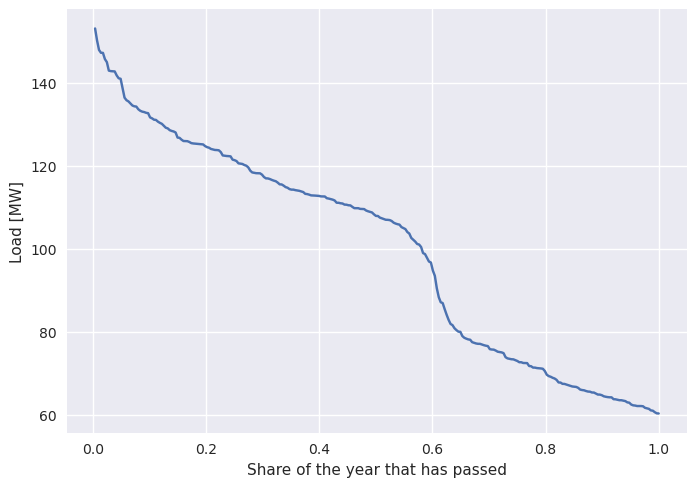

In [88]:
plt.plot(LDC.index, LDC.values) #Plot the load duration curve
#plt.plot(RDCL.index, RDCL.values) #Plot the residual load duration curve
plt.xlabel('Share of the year that has passed')
plt.ylabel('Load [MW]')
plt.show()


In [60]:
IFrame("./Figs/S4_Q21.pdf", width=600, height=350)

### **Q2.2. Solve and comment on profitability of plants**

*Solve the model and:*
1. *Plot sorted hourly prices.*
2. *Plot capacity factors for each generator.*
3. *The model solution automatically reports shadow values on constraints and variables using the syntax ```λ_x``` for a symbol ```x```. Explain how the following formula gets you the 'marginal economic value' of a generator (as defined in the main lecture note in eq. 16):*
```python
def marginalEconomicValue(model):
	return - pyDbs.pdSum(model.db['λ_Generation'].xs('u',level='_type') * model.hourlyCapFactors, 'h').add( 1000 * model.db['FOM'], fill_value = 0)
``` 
4. *Based on the first three, comment on the profitability of each of the three generators.*

*Hints:*
* *We solve the model simply using the ```m()``` syntax.*
* *Shadow values are reported with syntax ```λ_x```, with an added index level called ```_type```. This indicates whether the shadow variable is the value of an equilibrium constraint (```eq```), an upper bound (```u```) or similar.*

Solution status 0: Optimization terminated successfully.


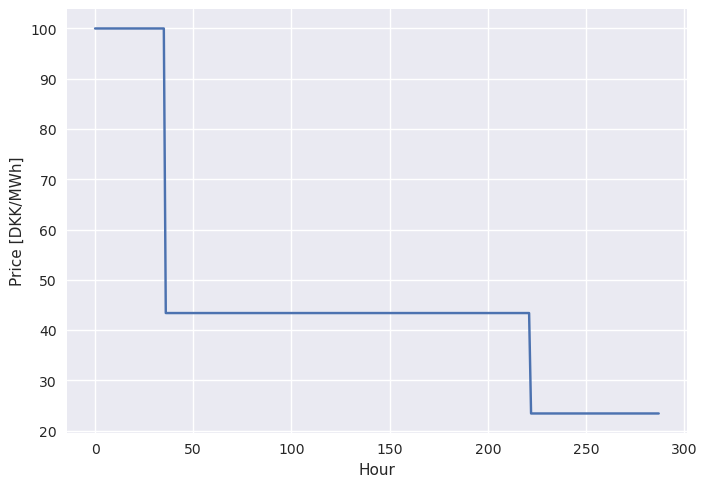

In [99]:
#1
m() #Solve the model
#2 Plot prices to see how many hours fall into each price 
eq_price = m.db['λ_equilibrium'].sort_values(ascending=False).values
plt.plot(eq_price)
plt.xlabel('Hour')
plt.ylabel('Price [DKK/MWh]')
plt.show()

In [102]:
#Cap generation
m.db['λ_Generation']

#Pivot table to see how many hours fall into each id 



h        id  _type
(1, 1)   A   l         0.000000
         B   l         0.000000
         C   l         0.000000
(1, 10)  A   l         0.000000
         B   l         0.000000
                        ...    
(9, 8)   B   u         0.000000
         C   u       -38.384940
(9, 9)   A   u       -19.977892
         B   u         0.000000
         C   u       -38.384940
Length: 1728, dtype: float64

In [94]:
m.db.symbols.keys()

dict_keys(['EmissionIntensity', 'FuelPrice', 'EmissionTax', 'MWP', 'Load', 'LoadVariation', 'GeneratingCapacity', 'FOM', 'OtherMC', 'FuelMix', 'CapVariation', 'id2hvt', 'id2tech', 'BFt', 'EmissionType', 'c', 'h', 'id', 'hvt', 'mc', 'Generation', 'HourlyDemand', 'λ_equilibrium', 'λ_Generation', 'λ_HourlyDemand', 'Welfare', 'FuelConsumption', 'Emissions'])

### **Q2.3. The effect of correlations**

*Compute the correlation coefficient between the hourly variation in demand $L_{c,h}$ and the wind turbines productivity $\gamma_{h,i}$. How do you think your answer to  Q2.2. would change if the correlation was negative?*

### **Q2.4. Include simple Ramp-Up-Constraints (RUR) in the model**

Assume that dispatchable plants (generators $A,B$) cannot simply increase its production from 0 to 100\% from hour to hour. Specifically, assume that:

$$\begin{align}
    E_{i,h}-E_{i,h-1} \leq \text{RUR}_i\cdot q_i, \qquad \forall i, h \tag{2}
\end{align}
$$

where $\text{RUR}_i\in[0,1]$ is a ramp-up rate. For the wind turbine ($C$), we assume that $\text{RUR}_i$ = 1, indicating that there are no ramp-up constraints here. 


*Incorporate the ramp-up constraint in the optimization problem. Derive the new first order conditions for $E_{i,h}$ and interpret briefly.*

*Hint: For the interpretation part, it might help to think of a scenario where - without the ramp-up constraints - a generator is not used in hour $h$, but very much needed in hour $h+1$.*

### **Q2.5. RUR constraints**

Now, assume specifically that the coal fired generator $i=A$ has a relatively low $\text{RUR}_A$ (0.25) and that the natural gas fired generator $i=B$ has a relatively high one ($\text{RUR}_B=$0.5).

In [ ]:
db['RUR'] = pd.Series([0.25, 0.5, 1], index = db['id'], name = 'RUR') # add to database

#### Q.2.5.1 Add the constraints to the model by specifying the inequality constraints.

The ```base.py``` file includes some auxiliary functions that can help you set up and adjust pandas objects. The following shows how to create a ```pd.Series``` with a value $1$ everywhere over the sets [h,id] and then add two extra levels to the index [h_constr, id_constr] that are simply copies of [h,id]:

In [ ]:
ones = pd.Series(1, index = m.globalDomains['Generation'])
onesExtraLevels = appIndexWithCopySeries(ones, ['h','id'], ['h_constr','id_constr']) # use appIndexWithCopySeries from base.py
onesExtraLevels

h         id  h_constr  id_constr
(1, 1)    A   (1, 1)    A            1
          B   (1, 1)    B            1
          C   (1, 1)    C            1
(1, 2)    A   (1, 2)    A            1
          B   (1, 2)    B            1
                                    ..
(12, 23)  B   (12, 23)  B            1
          C   (12, 23)  C            1
(12, 24)  A   (12, 24)  A            1
          B   (12, 24)  B            1
          C   (12, 24)  C            1
Length: 864, dtype: int64

You are also going to need to "lag" an index, that is use the syntax $h-1$. The following shows how to lag the index $h$ with 1 element (following the ordering in ```db['h']```):

In [ ]:
onesLagged = rollLevelS(onesExtraLevels.copy(), 'h', 1, order = db['h']) # use rollLevelS from base.py to offset the index 'h' with 1 element from db['h']
onesLagged

h         id  h_constr  id_constr
(12, 24)  A   (1, 1)    A            1
          B   (1, 1)    B            1
          C   (1, 1)    C            1
(1, 1)    A   (1, 2)    A            1
          B   (1, 2)    B            1
                                    ..
(12, 22)  B   (12, 23)  B            1
          C   (12, 23)  C            1
(12, 23)  A   (12, 24)  A            1
          B   (12, 24)  B            1
          C   (12, 24)  C            1
Length: 864, dtype: int64

Specifically, you are going to need this object ```A_ub``` to specify the RUR constraint:

In [ ]:
A_ub = onesExtraLevels.add(-onesLagged, fill_value=0)
A_ub.unstack(['h_constr','id_constr']).fillna(0).head(3) # the .head syntax just limits the number of rows to print

h_constr  (1, 1) (1, 2) (1, 1) (1, 2) (1, 1) (1, 2) (1, 10) (1, 11) (1, 10)  \
id_constr      A      A      B      B      C      C       A       A       B   
h      id                                                                     
(1, 1) A     1.0   -1.0    0.0    0.0    0.0    0.0     0.0     0.0     0.0   
       B     0.0    0.0    1.0   -1.0    0.0    0.0     0.0     0.0     0.0   
       C     0.0    0.0    0.0    0.0    1.0   -1.0     0.0     0.0     0.0   

h_constr  (1, 11)  ... (9, 6) (9, 7)           (9, 8)           (9, 9)       \
id_constr       B  ...      C      A    B    C      A    B    C      A    B   
h      id          ...                                                        
(1, 1) A      0.0  ...    0.0    0.0  0.0  0.0    0.0  0.0  0.0    0.0  0.0   
       B      0.0  ...    0.0    0.0  0.0  0.0    0.0  0.0  0.0    0.0  0.0   
       C      0.0  ...    0.0    0.0  0.0  0.0    0.0  0.0  0.0    0.0  0.0   

h_constr        
id_constr    C  
h      id       
(1, 1) A   0.0  
       B   0.0  
       C   0.0  

[3 rows x 864 columns]

*We are now ready to add the constraint ```rampUpRate``` to the model. Explain how ```m.b_ub``` and ```m.A_ub``` are specified below. Fill out the ```m.globalDomains``` part yourself.*

```python
m.globalDomains['rampUpRate'] = {Add relevant pd.MultiIndex here}
m.b_ub = [{'constrName': 'rampUpRate',
           'value': adjMultiIndex.bc(db['GeneratingCapacity'] * db['RUR'], db['h_constr']).rename_axis(index = {'id':'id_constr'})
          }] # Explain this
m.A_ub = [{'constrName': 'rampUpRate', 'varName': 'Generation',
           'value': A_ub # explain the A_ub matrix
          }]
```

#### Q.2.5.2 Compare sorted hourly prices before/after RUR constraints

*Solve the new model and show the sorted hourly prices with/without RUR constraints (see Q2.2). Explain why the RUR constraints imply that some hours have higher and some have lower prices?*

#### Q.2.5.3 Marginal economic value

*Derive the marginal economic value in this extended model (recall that we define this as $\partial \mathcal{L}/\partial q_i$) and comment briefly.*

#### Q.2.5.4 Compute Marginal Economic Value and Compare

*Compute marginal economic value and compare to before. Why does the marginal economic value of the wind generator drop, while the value of the natural gas generator $i=B$ increase?*